# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed
- convert the tracksters into some latent space and predict a link between them
- later extend this using edgeconv or sageconf to add information from the neighbourhood

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [27]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

from reco.dataset import TracksterPairs

In [28]:
# Apple silicon setup
# this ensures that the current MacOS version is at least 12.3+
# print(torch.backends.mps.is_available())
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [29]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [38]:
ds = TracksterPairs("data", N_FILES=10, balanced=True)
ds.x.shape

torch.Size([20938, 37])

In [51]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [52]:
ds.x.shape

torch.Size([20938, 37])

In [79]:
print("dataset balance:", float(sum(ds.y) / len(ds.y))) 

dataset balance: 0.5


In [80]:
loss_obj = torch.nn.BCELoss()

def train(model, opt, loader):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels.type(torch.int))
    return (correct / total)

In [81]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 18845, Test samples: 2093


In [82]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Dropout(),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

for epoch in range(0, 101):
    loss = train(model, optimizer, train_dl)
    scheduler.step()
    if epoch % 20 == 0:
        train_acc = test(model, train_dl)
        test_acc = test(model, test_dl)
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 163.5426, train acc: 0.8562, test acc: 0.8438
Epoch: 20, loss: 135.3120, train acc: 0.9129, test acc: 0.8724
Epoch: 40, loss: 130.6574, train acc: 0.9302, test acc: 0.8763
Epoch: 60, loss: 127.7396, train acc: 0.9364, test acc: 0.8767
Epoch: 80, loss: 124.1840, train acc: 0.9415, test acc: 0.8753
Epoch: 100, loss: 123.7796, train acc: 0.9422, test acc: 0.8786


In [83]:
pred = []
lab = []
for b, l in test_dl:
    pred += (model(b) > 0.5).type(torch.int).tolist()
    lab += l.tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f'Accuracy: {accuracy_score(lab, pred):.4f}')
print(f'Precision: {precision_score(lab, pred):.4f}')
print(f'Recall: {recall_score(lab, pred):.4f}')

TP: 950, TN: 889, FP: 178, FN: 76
Accuracy: 0.8786
Precision: 0.8422
Recall: 0.9259


# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [132]:
import uproot
import numpy as np
from reco.dataset import get_ground_truth, get_pair_tensor_builder
from reco.evaluation import evaluate
from reco.event import remap_tracksters, get_candidate_pairs
from reco.plotting import plot_sim_reco

file_name = "~/Data/multi/new_ntuples_14992862_996.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [136]:
eid = 0
# get candidate pairs
candidate_pairs, dst_map = get_candidate_pairs(tracksters, graphs, eid)
builder = get_pair_tensor_builder(tracksters, eid, dst_map)

# get ground truth
gt = get_ground_truth(tracksters, simtracksters, associations, eid)

In [137]:
_scaled_samples = []
for edge in candidate_pairs:
    sample = torch.tensor(builder(edge))
    scaled = scaler.transform(sample.reshape(1,-1))
    _scaled_samples.append(scaled)

samples = torch.tensor(np.array(_scaled_samples)).type(torch.float)

In [138]:
model.eval()
preds = model(samples)

In [139]:
out = (preds.reshape(1,-1)[0].detach().numpy() > 0.5)

In [141]:
# !must be little -> big
# some tracksters happen to both on left and right here
re = tracksters["raw_energy"].array()[eid]
merge_map = {a: b for (a, b), o in zip(candidate_pairs, out) if o and re[a] < 10 and re[b] > 10}
print(merge_map)

{6: 3, 7: 4, 8: 5, 9: 4, 11: 2, 12: 3, 13: 3, 14: 3, 15: 4, 16: 3, 17: 4, 19: 4, 20: 1, 21: 3, 22: 30, 23: 30, 25: 30, 26: 30, 27: 4, 29: 30, 32: 31, 33: 46, 34: 4, 36: 4, 37: 30, 39: 30, 40: 31, 41: 31, 42: 54, 45: 46, 47: 30, 48: 30, 49: 31, 50: 46, 51: 46, 52: 46, 53: 54, 55: 54, 56: 54, 57: 46, 58: 46, 59: 46, 60: 31, 64: 46, 65: 63, 66: 31, 67: 46, 68: 46, 70: 30, 71: 63, 72: 63, 73: 30, 74: 46, 75: 46, 76: 30, 77: 30, 78: 30, 79: 63, 80: 63, 82: 63, 83: 63, 84: 30, 87: 30, 88: 46, 91: 89}


In [142]:
reco = remap_tracksters(tracksters, merge_map, eid)

In [143]:
vx = reco["vertices_x"]
vy = reco["vertices_y"]
vz = reco["vertices_z"]
ve = reco["vertices_energy"]
vi = reco["vertices_indexes"]
vm = reco["vertices_multiplicity"]

gx = gt["vertices_x"]
gy = gt["vertices_y"]
gz = gt["vertices_z"]
ge = gt["vertices_energy"]
gi = gt["vertices_indexes"]
gm = gt["vertices_multiplicity"]

In [148]:
evaluate(vi, gi, ve, ge, vm, gm)

(0.7609818828920145, 0.7408300437958333, 0.7507707611219472)

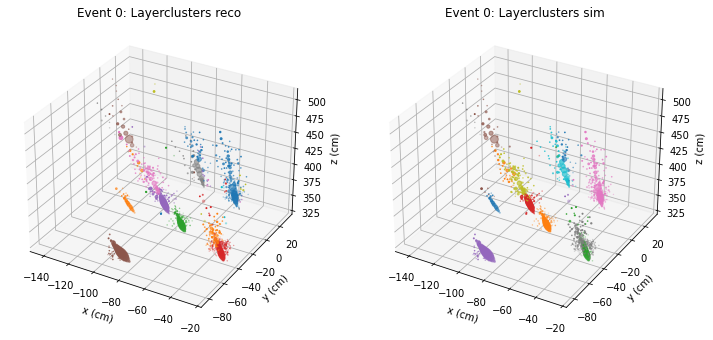

In [149]:
plot_sim_reco(vx, vy, vz, ve, gx, gy, gz, ge, gi, gm, eid, legend=False)

In [147]:
print(len(gi))

19
